In [1]:
import os

In [2]:
from data.dataset import Dataset
from data.feature import Featurizer
from data.dataloader import DataLoader
from methods.ridge_method import RidgeMethod

import numpy as np
from visualize import visualize_energy

In [3]:
featurizer = Featurizer()
#trimer_dataset = Dataset.from_file('xe3_50.xyz', 3, featurizer)
#energy_base = trimer_dataset[-1][1][0]
dimer_dataset = Dataset.from_file('dataset/xe2_50.xyz', 2, featurizer)
trimer_dataset = Dataset.from_file('dataset/xe3_50.xyz', 3, featurizer)
rand_trimer_dataset = Dataset.from_file('dataset/xe3_dataset_dft.xyz', 3, featurizer)

In [4]:
dimer_train, dimer_val = dimer_dataset.split(
    [list(range(40)),
     list(range(40, 50))])
trimer_train, trimer_val = trimer_dataset.split(
    [list(range(40)),
     list(range(40, 50))])
rand_trimer_train, rand_trimer_val = rand_trimer_dataset.split(
    [list(range(5500)), 
     list(range(5500, len(rand_trimer_dataset)))])
train = DataLoader([dimer_train, trimer_train, rand_trimer_train])
val = DataLoader([dimer_val, trimer_val, rand_trimer_val])

(array([4.609e+03, 4.310e+02, 6.300e+01, 2.380e+02, 1.920e+02, 2.900e+01,
        1.100e+01, 2.000e+00, 3.000e+00, 2.000e+00]),
 array([-205862.80053373, -205862.48635918, -205862.17218463,
        -205861.85801008, -205861.54383553, -205861.22966099,
        -205860.91548644, -205860.60131189, -205860.28713734,
        -205859.97296279, -205859.65878824]),
 <BarContainer object of 10 artists>)

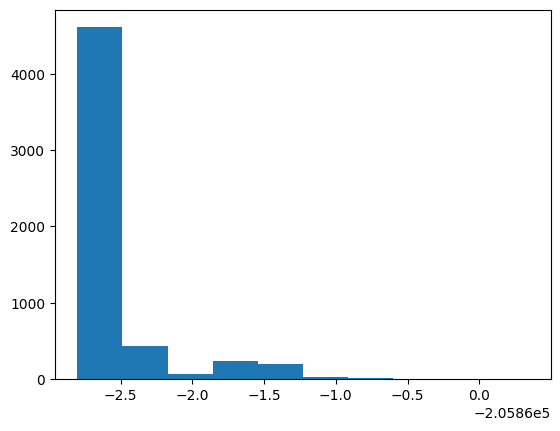

In [5]:
import matplotlib.pyplot as plt
plt.hist(train.y)

In [6]:
from methods.mlp_method import MlpMethod

method = MlpMethod(train, hidden=[1], epochs=5025, lr=1e3, wd=1e-12)

In [37]:
method.train()

  4%|▎         | 181/5025 [00:00<00:05, 909.06it/s]

0: 42379632640.0000
0: 42276872192.0000
1: 42127011840.0000
1: 42233704448.0000
2: 41966092288.0000
2: 41682468864.0000
3: 41720713216.0000
3: 41576513536.0000
4: 41487097856.0000
4: 41459032064.0000
5: 41389793280.0000
5: 41148030976.0000
6: 41342316544.0000
6: 40662282240.0000
7: 40888107008.0000
7: 42049835008.0000
8: 40752648192.0000
8: 41124216832.0000
9: 40834961408.0000
9: 40628019200.0000
10: 40710627328.0000
10: 40083759104.0000
11: 40329904128.0000
11: 41493925888.0000
12: 40382459904.0000
12: 39338352640.0000
13: 40411762688.0000
13: 38953664512.0000
14: 40260747264.0000
14: 40348696576.0000
15: 40256966656.0000
15: 39513264128.0000
16: 40069779456.0000
16: 40506982400.0000
17: 40080130048.0000
17: 39104700416.0000
18: 40110579712.0000
18: 39054381056.0000
19: 39798611968.0000
19: 39302840320.0000
20: 39569072128.0000
20: 40402259968.0000
21: 39464734720.0000
21: 39517814784.0000
22: 39817056256.0000
22: 39525634048.0000
23: 39746576384.0000
23: 40674783232.0000
24: 39735541

  8%|▊         | 379/5025 [00:00<00:04, 962.87it/s]

181: 32885784576.0000
181: 23411650560.0000
182: 33182277632.0000
182: 28143857664.0000
183: 30123937792.0000
183: 36137988096.0000
184: 30567948288.0000
184: 33753167872.0000
185: 30620782592.0000
185: 34623676416.0000
186: 30603026432.0000
186: 28341153792.0000
187: 30271457280.0000
187: 28935073792.0000
188: 32726718464.0000
188: 25003536384.0000
189: 29393946624.0000
189: 36067282944.0000
190: 32138643456.0000
190: 28838901760.0000
191: 30904786944.0000
191: 30330417152.0000
192: 31251941376.0000
192: 32714246144.0000
193: 28851791872.0000
193: 33566916608.0000
194: 28972589056.0000
194: 33538404352.0000
195: 32915687424.0000
195: 28635996160.0000
196: 30101753856.0000
196: 31913060352.0000
197: 29793931264.0000
197: 33450338304.0000
198: 29225205760.0000
198: 27794751488.0000
199: 30764756992.0000
199: 25273786368.0000
200: 30941804544.0000
200: 22736513024.0000
201: 30497908736.0000
201: 26754689024.0000
202: 30018912256.0000
202: 30807742464.0000
203: 28921036800.0000
203: 37390

 11%|█▏        | 577/5025 [00:00<00:04, 975.22it/s]

379: 30749413376.0000
379: 26496262144.0000
380: 30434611200.0000
380: 27125577728.0000
381: 27440107520.0000
381: 33048866816.0000
382: 27597094912.0000
382: 24974733312.0000
383: 29896157184.0000
383: 24477995008.0000
384: 30276816896.0000
384: 32418873344.0000
385: 27908638720.0000
385: 22457360384.0000
386: 31443245056.0000
386: 27124137984.0000
387: 27593119744.0000
387: 28373950464.0000
388: 28759201792.0000
388: 31017947136.0000
389: 30742994944.0000
389: 29146779648.0000
390: 29262934016.0000
390: 25097265152.0000
391: 27897905152.0000
391: 34440744960.0000
392: 28754337792.0000
392: 33650593792.0000
393: 30075994112.0000
393: 28354490368.0000
394: 28660146176.0000
394: 25089372160.0000
395: 28749555712.0000
395: 31798120448.0000
396: 30070470656.0000
396: 28340097024.0000
397: 30677944320.0000
397: 24474181632.0000
398: 29915113472.0000
398: 25080037376.0000
399: 29045446656.0000
399: 29158748160.0000
400: 31084261376.0000
400: 27118159872.0000
401: 26547724288.0000
401: 32405

 13%|█▎        | 675/5025 [00:00<00:04, 947.97it/s]

577: 32134725632.0000
577: 21890537472.0000
578: 30033381376.0000
578: 30295951360.0000
579: 29639516160.0000
579: 28194363392.0000
580: 31084183552.0000
580: 25042419712.0000
581: 30296186880.0000
581: 22940848128.0000
582: 30033385472.0000
582: 27143993344.0000
583: 32003479552.0000
583: 23991912448.0000
584: 28194615296.0000
584: 35024379904.0000
585: 28194635776.0000
585: 32397500416.0000
586: 27275489280.0000
586: 30296309760.0000
587: 28982835200.0000
587: 27143630848.0000
588: 31478325248.0000
588: 24516706304.0000
589: 28326619136.0000
589: 27143639040.0000
590: 30164844544.0000
590: 25042423808.0000
591: 28194643968.0000
591: 35024396288.0000
592: 27932043264.0000
592: 25042419712.0000
593: 30296195072.0000
593: 28194299904.0000
594: 32265809920.0000
594: 17162667008.0000
595: 28063426560.0000
595: 29771218944.0000
596: 27275802624.0000
596: 31343710208.0000
597: 30428008448.0000
597: 32921255936.0000
598: 28720173056.0000
598: 30817146880.0000
599: 27407339520.0000
599: 32919

 17%|█▋        | 866/5025 [00:00<00:04, 932.57it/s]

764: 27794378752.0000
764: 29776846848.0000
765: 29904941056.0000
765: 29776769024.0000
766: 27922673664.0000
766: 27153590272.0000
767: 31744000000.0000
767: 24017387520.0000
768: 28193927168.0000
768: 30289661952.0000
769: 29633886208.0000
769: 26069839872.0000
770: 30033057792.0000
770: 29263065088.0000
771: 29633908736.0000
771: 24529793024.0000
772: 30560536576.0000
772: 22419841024.0000
773: 27281397760.0000
773: 35022970880.0000
774: 28992163840.0000
774: 32399654912.0000
775: 29120516096.0000
775: 27666452480.0000
776: 30432176128.0000
776: 29776343040.0000
777: 29248868352.0000
777: 32399650816.0000
778: 28065562624.0000
778: 30289793024.0000
779: 30688888832.0000
779: 20823498752.0000
780: 29776287744.0000
780: 31886077952.0000
781: 30033055744.0000
781: 22419730432.0000
782: 28721348608.0000
782: 32399575040.0000
783: 28849797120.0000
783: 29776044032.0000
784: 28721287168.0000
784: 25043046400.0000
785: 28193941504.0000
785: 27152123904.0000
786: 30290417664.0000
786: 29260

 21%|██        | 1054/5025 [00:01<00:04, 925.51it/s]

949: 32914061312.0000
950: 28991107072.0000
950: 32399343616.0000
951: 28721115136.0000
951: 30290796544.0000
952: 25160355840.0000
952: 29775355904.0000
953: 30173728768.0000
953: 30290767872.0000
954: 28053448704.0000
954: 25042939904.0000
955: 29505855488.0000
955: 33429049344.0000
956: 30688933888.0000
956: 25556754432.0000
957: 29761966080.0000
957: 25043304448.0000
958: 29649475584.0000
958: 32911257600.0000
959: 29777833984.0000
959: 30288261120.0000
960: 28066476032.0000
960: 30287958016.0000
961: 29905854464.0000
961: 25552809984.0000
962: 28976623616.0000
962: 32400785408.0000
963: 30434570240.0000
963: 24535910400.0000
964: 29779204096.0000
964: 32400846848.0000
965: 30180403200.0000
965: 29778993152.0000
966: 28066816000.0000
966: 31891865600.0000
967: 33966157824.0000
967: 14046354432.0000
968: 30287921152.0000
968: 24024221696.0000
969: 31344273408.0000
969: 24023261184.0000
970: 29905534976.0000
970: 30288400384.0000
971: 30433406976.0000
971: 25043496960.0000
972: 31216

 25%|██▍       | 1247/5025 [00:01<00:04, 943.64it/s]

1139: 27936102400.0000
1139: 35023204352.0000
1140: 27139926016.0000
1140: 37647306752.0000
1141: 29904064512.0000
1141: 26635122688.0000
1142: 29376995328.0000
1142: 32398979072.0000
1143: 27796520960.0000
1143: 29774299136.0000
1144: 29506381824.0000
1144: 26630940672.0000
1145: 30422396928.0000
1145: 21897830400.0000
1146: 27798095872.0000
1146: 32398188544.0000
1147: 31872088064.0000
1147: 17686951936.0000
1148: 31610624000.0000
1148: 27145166848.0000
1149: 28983386112.0000
1149: 35024367616.0000
1150: 28851478528.0000
1150: 32397320192.0000
1151: 27669909504.0000
1151: 27670063104.0000
1152: 29376727040.0000
1152: 27670265856.0000
1153: 29376737280.0000
1153: 31868006400.0000
1154: 28587372544.0000
1154: 37653229568.0000
1155: 30033846272.0000
1155: 29237952512.0000
1156: 25832531968.0000
1156: 34493669376.0000
1157: 30034067456.0000
1157: 25042708480.0000
1158: 29376927744.0000
1158: 29767436288.0000
1159: 30948411392.0000
1159: 27672215552.0000
1160: 27282345984.0000
1160: 34491

 29%|██▊       | 1437/5025 [00:01<00:03, 927.76it/s]

1331: 27667283968.0000
1331: 32398807040.0000
1332: 26484482048.0000
1332: 35541356544.0000
1333: 30292045824.0000
1333: 28703244288.0000
1334: 29506332672.0000
1334: 32398860288.0000
1335: 28323303424.0000
1335: 29774620672.0000
1336: 28720906240.0000
1336: 28183515136.0000
1337: 29118980096.0000
1337: 30290944000.0000
1338: 27268585472.0000
1338: 32399337472.0000
1339: 30431686656.0000
1339: 25043046400.0000
1340: 30033047552.0000
1340: 20823824384.0000
1341: 28721436672.0000
1341: 34510196736.0000
1342: 28721551360.0000
1342: 26068099072.0000
1343: 27138373632.0000
1343: 37134397440.0000
1344: 25298739200.0000
1344: 32400465920.0000
1345: 27920414720.0000
1345: 22930597888.0000
1346: 27137097728.0000
1346: 35529330688.0000
1347: 30562195456.0000
1347: 30285737984.0000
1348: 28975151104.0000
1348: 27162611712.0000
1349: 27664869376.0000
1349: 30284279808.0000
1350: 29099452416.0000
1350: 26044628992.0000
1351: 27664599040.0000
1351: 26535927808.0000
1352: 31503497216.0000
1352: 25539

 33%|███▎      | 1638/5025 [00:01<00:03, 960.99it/s]

1523: 29248149504.0000
1523: 26074126336.0000
1524: 31087224832.0000
1524: 24527296512.0000
1525: 27537975296.0000
1525: 37131538432.0000
1526: 29763753984.0000
1526: 29775237120.0000
1527: 26624172032.0000
1527: 33430454272.0000
1528: 31345031168.0000
1528: 21387714560.0000
1529: 26753060864.0000
1529: 38162911232.0000
1530: 30689044480.0000
1530: 20826365952.0000
1531: 29107814400.0000
1531: 26635677696.0000
1532: 29904134144.0000
1532: 31322263552.0000
1533: 28193966080.0000
1533: 31883972608.0000
1534: 30431381504.0000
1534: 28182073344.0000
1535: 28990767104.0000
1535: 28181831680.0000
1536: 31473610752.0000
1536: 22419384320.0000
1537: 28065370112.0000
1537: 32399511552.0000
1538: 29904545792.0000
1538: 21338044416.0000
1539: 27923091456.0000
1539: 26068230144.0000
1540: 30433198080.0000
1540: 26063577088.0000
1541: 28849420288.0000
1541: 22929600512.0000
1542: 28194136064.0000
1542: 34518867968.0000
1543: 28974858240.0000
1543: 29783142400.0000
1544: 28849291264.0000
1544: 29784

 37%|███▋      | 1841/5025 [00:01<00:03, 983.93it/s]

1732: 25564205056.0000
1733: 27798593536.0000
1733: 30293780480.0000
1734: 29902931968.0000
1734: 27147415552.0000
1735: 30559381504.0000
1735: 25042558976.0000
1736: 29636837376.0000
1736: 20311967744.0000
1737: 29903220736.0000
1737: 22417551360.0000
1738: 29773527040.0000
1738: 34504421376.0000
1739: 27271145472.0000
1739: 30812319744.0000
1740: 27934609408.0000
1740: 31329814528.0000
1741: 27011129344.0000
1741: 31882883072.0000
1742: 30302363648.0000
1742: 29775421440.0000
1743: 27010828288.0000
1743: 32914374656.0000
1744: 30560319488.0000
1744: 25043054592.0000
1745: 28721319936.0000
1745: 30803648512.0000
1746: 28193923072.0000
1746: 29777129472.0000
1747: 30033100800.0000
1747: 29266685952.0000
1748: 28066074624.0000
1748: 32399972352.0000
1749: 27937628160.0000
1749: 37646290944.0000
1750: 29235298304.0000
1750: 27152564224.0000
1751: 28592611328.0000
1751: 32399302656.0000
1752: 28592064512.0000
1752: 31882307584.0000
1753: 29506416640.0000
1753: 30292725760.0000
1754: 27934

 41%|████      | 2046/5025 [00:02<00:02, 1003.31it/s]

1937: 29259311104.0000
1938: 29107712000.0000
1938: 28181794816.0000
1939: 30688927744.0000
1939: 19796635648.0000
1940: 32399808512.0000
1940: 24530984960.0000
1941: 28465369088.0000
1941: 33425405952.0000
1942: 28322007040.0000
1942: 29777203200.0000
1943: 30560899072.0000
1943: 27154712576.0000
1944: 28465833984.0000
1944: 26580480000.0000
1945: 26882578432.0000
1945: 30288404480.0000
1946: 26081349632.0000
1946: 25552054272.0000
1947: 28320657408.0000
1947: 27665162240.0000
1948: 28445749248.0000
1948: 27664826368.0000
1949: 28974176256.0000
1949: 29785206784.0000
1950: 32279779328.0000
1950: 24550588416.0000
1951: 28725309440.0000
1951: 34525175808.0000
1952: 33058203648.0000
1952: 21928046592.0000
1953: 28069167104.0000
1953: 30285082624.0000
1954: 27286753280.0000
1954: 35022417920.0000
1955: 28067057664.0000
1955: 30287806464.0000
1956: 27010334720.0000
1956: 28177240064.0000
1957: 28721768448.0000
1957: 34511298560.0000
1958: 27937843200.0000
1958: 27095117824.0000
1959: 28849

 45%|████▍     | 2249/5025 [00:02<00:02, 995.89it/s] 

2145: 29377767424.0000
2145: 32909017088.0000
2146: 31217139712.0000
2146: 22422843392.0000
2147: 27665403904.0000
2147: 37643583488.0000
2148: 27538833408.0000
2148: 34516832256.0000
2149: 28975808512.0000
2149: 29780344832.0000
2150: 30688614400.0000
2150: 31894151168.0000
2151: 28976498688.0000
2151: 26062252032.0000
2152: 26883020800.0000
2152: 35531091968.0000
2153: 28194013184.0000
2153: 32401215488.0000
2154: 29631102976.0000
2154: 24539201536.0000
2155: 30159732736.0000
2155: 21318809600.0000
2156: 27009994752.0000
2156: 29782290432.0000
2157: 30033676288.0000
2157: 27163557888.0000
2158: 29378844672.0000
2158: 20808929280.0000
2159: 29378918400.0000
2159: 31902322688.0000
2160: 29658124288.0000
2160: 32402546688.0000
2161: 29504247808.0000
2161: 30285033472.0000
2162: 27009978368.0000
2162: 29175582720.0000
2163: 29907959808.0000
2163: 25045147648.0000
2164: 29657610240.0000
2164: 30284388352.0000
2165: 27664820224.0000
2165: 25045397504.0000
2166: 29908592640.0000
2166: 22426

 49%|████▉     | 2456/5025 [00:02<00:02, 1001.32it/s]

2350: 25046298624.0000
2351: 30158436352.0000
2351: 25046589440.0000
2352: 31749693440.0000
2352: 24054415360.0000
2353: 32684646400.0000
2353: 20807938048.0000
2354: 31092617216.0000
2354: 25044836352.0000
2355: 30688598016.0000
2355: 27665342464.0000
2356: 28976177152.0000
2356: 27665573888.0000
2357: 30307291136.0000
2357: 31891091456.0000
2358: 28977344512.0000
2358: 29264648192.0000
2359: 27795167232.0000
2359: 29775200256.0000
2360: 30291648512.0000
2360: 22417930240.0000
2361: 30826334208.0000
2361: 29772845056.0000
2362: 28063819776.0000
2362: 37127135232.0000
2363: 29902245888.0000
2363: 25042423808.0000
2364: 28719917056.0000
2364: 32397293568.0000
2365: 30426560512.0000
2365: 22943256576.0000
2366: 28984213504.0000
2366: 30827302912.0000
2367: 28984231936.0000
2367: 20315633664.0000
2368: 28587685888.0000
2368: 32397144064.0000
2369: 27802146816.0000
2369: 34496704512.0000
2370: 28719816704.0000
2370: 25570471936.0000
2371: 26224250880.0000
2371: 37124395008.0000
2372: 29901

 53%|█████▎    | 2660/5025 [00:02<00:02, 999.98it/s] 

2554: 27281702912.0000
2554: 34492280832.0000
2555: 27671863296.0000
2555: 31863279616.0000
2556: 29376976896.0000
2556: 25577324544.0000
2557: 31081869312.0000
2557: 27672072192.0000
2558: 30424678400.0000
2558: 30301050880.0000
2559: 28328996864.0000
2559: 25042685952.0000
2560: 28719687680.0000
2560: 31865417728.0000
2561: 28852568064.0000
2561: 30299713536.0000
2562: 30558253056.0000
2562: 32396832768.0000
2563: 26748434432.0000
2563: 33989306368.0000
2564: 28847005696.0000
2564: 30827503616.0000
2565: 29901576192.0000
2565: 32397254656.0000
2566: 29508415488.0000
2566: 27669526528.0000
2567: 30558713856.0000
2567: 27669266432.0000
2568: 29902108672.0000
2568: 24517623808.0000
2569: 27931439104.0000
2569: 37126270976.0000
2570: 27405770752.0000
2570: 32397680640.0000
2571: 28982231040.0000
2571: 26620405760.0000
2572: 31741065216.0000
2572: 25042429952.0000
2573: 27537876992.0000
2573: 32922013696.0000
2574: 27537876992.0000
2574: 30819794944.0000
2575: 27143401472.0000
2575: 34499

 57%|█████▋    | 2864/5025 [00:02<00:02, 1001.77it/s]

2760: 28850063360.0000
2760: 25042784256.0000
2761: 28720824320.0000
2761: 35023388672.0000
2762: 29109133312.0000
2762: 24007190528.0000
2763: 29903421440.0000
2763: 29253900288.0000
2764: 30689517568.0000
2764: 26624733184.0000
2765: 27537852416.0000
2765: 32397680640.0000
2766: 28851331072.0000
2766: 29244141568.0000
2767: 32001912832.0000
2767: 26098728960.0000
2768: 27802333184.0000
2768: 32397090816.0000
2769: 28587542528.0000
2769: 32397041664.0000
2770: 28984401920.0000
2770: 27141107712.0000
2771: 25959411712.0000
2771: 38182572032.0000
2772: 30823155712.0000
2772: 22414499840.0000
2773: 29901369344.0000
2773: 27140960256.0000
2774: 28195141632.0000
2774: 31867414528.0000
2775: 29244362752.0000
2775: 35025010688.0000
2776: 28454963200.0000
2776: 32926576640.0000
2777: 29249341440.0000
2777: 24512925696.0000
2778: 28587352064.0000
2778: 34495385600.0000
2779: 27405723648.0000
2779: 35025043456.0000
2780: 26229438464.0000
2780: 30298738688.0000
2781: 30950453248.0000
2781: 29768

 63%|██████▎   | 3176/5025 [00:03<00:01, 1015.89it/s]

2968: 32398540800.0000
2969: 28453584896.0000
2969: 37129658368.0000
2970: 29109653504.0000
2970: 27148939264.0000
2971: 27400198144.0000
2971: 29773840384.0000
2972: 30300450816.0000
2972: 25561102336.0000
2973: 28194074624.0000
2973: 31880269824.0000
2974: 30689275904.0000
2974: 27149066240.0000
2975: 27278663680.0000
2975: 30810689536.0000
2976: 25569267712.0000
2976: 39754674176.0000
2977: 29247270912.0000
2977: 31880249344.0000
2978: 28323690496.0000
2978: 32917164032.0000
2979: 27140919296.0000
2979: 30810847232.0000
2980: 28591075328.0000
2980: 32916987904.0000
2981: 27667406848.0000
2981: 30809849856.0000
2982: 28064681984.0000
2982: 32915877888.0000
2983: 27537942528.0000
2983: 32914866176.0000
2984: 27666722816.0000
2984: 32399546368.0000
2985: 29120684032.0000
2985: 33424912384.0000
2986: 30433118208.0000
2986: 29778006016.0000
2987: 32145786880.0000
2987: 24534675456.0000
2988: 30033174528.0000
2988: 30287888384.0000
2989: 29377650688.0000
2989: 35022630912.0000
2990: 28976

 65%|██████▌   | 3278/5025 [00:03<00:01, 1007.38it/s]

3176: 29755002880.0000
3176: 27163246592.0000
3177: 29378785280.0000
3177: 25045217280.0000
3178: 29127948288.0000
3178: 27664875520.0000
3179: 28849278976.0000
3179: 28668608512.0000
3180: 28974729216.0000
3180: 24543541248.0000
3181: 26229616640.0000
3181: 35022180352.0000
3182: 24641159168.0000
3182: 30786461696.0000
3183: 28319772672.0000
3183: 24544014336.0000
3184: 30159052800.0000
3184: 27664834560.0000
3185: 29378856960.0000
3185: 27664832512.0000
3186: 30688616448.0000
3186: 20808699904.0000
3187: 29504124928.0000
3187: 25045573632.0000
3188: 32652931072.0000
3188: 22426902528.0000
3189: 27134748672.0000
3189: 32403308544.0000
3190: 26355281920.0000
3190: 39760744448.0000
3191: 30563909632.0000
3191: 20307300352.0000
3192: 28474476544.0000
3192: 34521464832.0000
3193: 26606143488.0000
3193: 27665035264.0000
3194: 28849299456.0000
3194: 27665235968.0000
3195: 31746125824.0000
3195: 21915869184.0000
3196: 28976769024.0000
3196: 27666032640.0000
3197: 30560714752.0000
3197: 22419

 69%|██████▉   | 3479/5025 [00:03<00:01, 977.59it/s] 

3375: 31349483520.0000
3375: 20855545856.0000
3376: 31738902528.0000
3376: 25043017728.0000
3377: 28841099264.0000
3377: 30838609920.0000
3378: 30156054528.0000
3378: 30302513152.0000
3379: 28330156032.0000
3379: 25578659840.0000
3380: 32396402688.0000
3380: 21342953472.0000
3381: 31215439872.0000
3381: 21389213696.0000
3382: 28719673344.0000
3382: 34491543552.0000
3383: 28195856384.0000
3383: 32396558336.0000
3384: 29376937984.0000
3384: 30300659712.0000
3385: 28453433344.0000
3385: 35025436672.0000
3386: 32263806976.0000
3386: 21882544128.0000
3387: 29118529536.0000
3387: 26607804416.0000
3388: 32396677120.0000
3388: 25042739200.0000
3389: 32273096704.0000
3389: 17155084288.0000
3390: 26881267712.0000
3390: 37655511040.0000
3391: 27672526848.0000
3391: 25578151936.0000
3392: 28329525248.0000
3392: 22946981888.0000
3393: 28719693824.0000
3393: 27140585472.0000
3394: 29636784128.0000
3394: 28199362560.0000
3395: 31476531200.0000
3395: 30297030656.0000
3396: 26487390208.0000
3396: 35024

 73%|███████▎  | 3683/5025 [00:03<00:01, 997.31it/s]

3573: 31858790400.0000
3574: 27673360384.0000
3574: 25043189760.0000
3575: 30692347904.0000
3575: 27135899648.0000
3576: 30557982720.0000
3576: 26598440960.0000
3577: 28585347072.0000
3577: 32933744640.0000
3578: 27942139904.0000
3578: 31858741248.0000
3579: 31335538688.0000
3579: 29228380160.0000
3580: 29108377600.0000
3580: 30303959040.0000
3581: 28465883136.0000
3581: 22412879872.0000
3582: 27000561664.0000
3582: 36104548352.0000
3583: 30169731072.0000
3583: 21874270208.0000
3584: 30035005440.0000
3584: 21874176000.0000
3585: 28854532096.0000
3585: 27674095616.0000
3586: 29377464320.0000
3586: 27674161152.0000
3587: 29512286208.0000
3587: 27134943232.0000
3588: 28719775744.0000
3588: 31382761472.0000
3589: 29780516864.0000
3589: 22413258752.0000
3590: 28586129408.0000
3590: 35558313984.0000
3591: 28985053184.0000
3591: 29769455616.0000
3592: 26488987648.0000
3592: 23463284736.0000
3593: 30689382400.0000
3593: 22418923520.0000
3594: 28721582080.0000
3594: 29268951040.0000
3595: 29377

 77%|███████▋  | 3886/5025 [00:03<00:01, 978.82it/s] 

3784: 32893726720.0000
3785: 27664429056.0000
3785: 35509796864.0000
3786: 29381752832.0000
3786: 34533355520.0000
3787: 30035329024.0000
3787: 24558018560.0000
3788: 27910387712.0000
3788: 25047498752.0000
3789: 27381039104.0000
3789: 29786693632.0000
3790: 27664531456.0000
3790: 29785225216.0000
3791: 26355240960.0000
3791: 35022135296.0000
3792: 28849281024.0000
3792: 23431274496.0000
3793: 27539202048.0000
3793: 30285225984.0000
3794: 30437048320.0000
3794: 28168308736.0000
3795: 26606221312.0000
3795: 39759937536.0000
3796: 31343452160.0000
3796: 24046063616.0000
3797: 29253511168.0000
3797: 31898996736.0000
3798: 27918336000.0000
3798: 25551953920.0000
3799: 31089664000.0000
3799: 27155634176.0000
3800: 31616090112.0000
3800: 22933952512.0000
3801: 27269011456.0000
3801: 30291478528.0000
3802: 28720857088.0000
3802: 27667226624.0000
3803: 30689173504.0000
3803: 26632677376.0000
3804: 28987674624.0000
3804: 28189175808.0000
3805: 29115801600.0000
3805: 31874854912.0000
3806: 27932

 84%|████████▎ | 4198/5025 [00:04<00:00, 1007.39it/s]

3994: 29634775040.0000
3994: 29257330688.0000
3995: 29376796672.0000
3995: 25565167616.0000
3996: 29902252032.0000
3996: 27143507968.0000
3997: 26749136896.0000
3997: 35555291136.0000
3998: 28188637184.0000
3998: 37654474752.0000
3999: 32006217728.0000
3999: 24508137472.0000
4000: 29109022720.0000
4000: 29765894144.0000
4001: 29124722688.0000
4001: 29764980736.0000
4002: 28333070336.0000
4002: 29764468736.0000
4003: 29764243456.0000
4003: 30308179968.0000
4004: 30172225536.0000
4004: 25044287488.0000
4005: 27947976704.0000
4005: 31853252608.0000
4006: 28333381632.0000
4006: 28759363584.0000
4007: 29242570752.0000
4007: 31858511872.0000
4008: 30960594944.0000
4008: 21877850112.0000
4009: 28585889792.0000
4009: 32396439552.0000
4010: 27282472960.0000
4010: 29767155712.0000
4011: 30291036160.0000
4011: 31862312960.0000
4012: 26491338752.0000
4012: 32931581952.0000
4013: 28196042752.0000
4013: 31861696512.0000
4014: 30814171136.0000
4014: 22948820992.0000
4015: 29377099776.0000
4015: 24507

 88%|████████▊ | 4400/5025 [00:04<00:00, 993.16it/s] 

4198: 27922384896.0000
4198: 31889231872.0000
4199: 29505212416.0000
4199: 25043482624.0000
4200: 29505200128.0000
4200: 24532719616.0000
4201: 28721676288.0000
4201: 29776607232.0000
4202: 29891555328.0000
4202: 29775616000.0000
4203: 29248106496.0000
4203: 34506477568.0000
4204: 31215855616.0000
4204: 27667914752.0000
4205: 30559219712.0000
4205: 25042458624.0000
4206: 31215529984.0000
4206: 24517550080.0000
4207: 31215427584.0000
4207: 25570525184.0000
4208: 30954897408.0000
4208: 19787008000.0000
4209: 30033694720.0000
4209: 27141246976.0000
4210: 29244313600.0000
4210: 32396881920.0000
4211: 30033932288.0000
4211: 29768163328.0000
4212: 29251960832.0000
4212: 32396689408.0000
4213: 30291980288.0000
4213: 29767761920.0000
4214: 28852957184.0000
4214: 25042757632.0000
4215: 27538503680.0000
4215: 35025711104.0000
4216: 28195811328.0000
4216: 30834843648.0000
4217: 29510262784.0000
4217: 27138744320.0000
4218: 28328816640.0000
4218: 35557998592.0000
4219: 28328574976.0000
4219: 28203

 90%|████████▉ | 4500/5025 [00:04<00:00, 987.06it/s]

4400: 27786260480.0000
4400: 37637853184.0000
4401: 31628023808.0000
4401: 23419551744.0000
4402: 28442974208.0000
4402: 29785997312.0000
4403: 29130747904.0000
4403: 35022077952.0000
4404: 27260272640.0000
4404: 32402583552.0000
4405: 30814193664.0000
4405: 22424838144.0000
4406: 29353295872.0000
4406: 20307902464.0000
4407: 30159474688.0000
4407: 27161399296.0000
4408: 29529321472.0000
4408: 30286098432.0000
4409: 31090782208.0000
4409: 24536924160.0000
4410: 29651607552.0000
4410: 29198077952.0000
4411: 28193937408.0000
4411: 27155746816.0000
4412: 31999924224.0000
4412: 24022487040.0000
4413: 31744344064.0000
4413: 22420111360.0000
4414: 31216308224.0000
4414: 24528150528.0000
4415: 29119000576.0000
4415: 26594416640.0000
4416: 29774403584.0000
4416: 32398839808.0000
4417: 27935174656.0000
4417: 35541430272.0000
4418: 27935051776.0000
4418: 35023437824.0000
4419: 28591177728.0000
4419: 35023454208.0000
4420: 29644376064.0000
4420: 30810615808.0000
4421: 28850264064.0000
4421: 30292

 93%|█████████▎| 4695/5025 [00:04<00:00, 955.63it/s]

4587: 28189663232.0000
4588: 29115985920.0000
4588: 32398077952.0000
4589: 30298015744.0000
4589: 29771767808.0000
4590: 30689898496.0000
4590: 29246279680.0000
4591: 28326330368.0000
4591: 30825168896.0000
4592: 26752126976.0000
4592: 32924622848.0000
4593: 30427111424.0000
4593: 22941026304.0000
4594: 26881249280.0000
4594: 37127172096.0000
4595: 28194340864.0000
4595: 32398077952.0000
4596: 30033172480.0000
4596: 24521500672.0000
4597: 30168031232.0000
4597: 31875010560.0000
4598: 30558783488.0000
4598: 25042444288.0000
4599: 27145744384.0000
4599: 27670835200.0000
4600: 30691082240.0000
4600: 24510713856.0000
4601: 28062408704.0000
4601: 30836312064.0000
4602: 30167908352.0000
4602: 24509102080.0000
4603: 26757859328.0000
4603: 29767544832.0000
4604: 29376917504.0000
4604: 25042710528.0000
4605: 28195594240.0000
4605: 34493353984.0000
4606: 28594866176.0000
4606: 25042647040.0000
4607: 28586827776.0000
4607: 37122494464.0000
4608: 26755547136.0000
4608: 27671023616.0000
4609: 28719

 97%|█████████▋| 4892/5025 [00:05<00:00, 962.17it/s]

4785: 27406499840.0000
4785: 32397410304.0000
4786: 27406245888.0000
4786: 30297378816.0000
4787: 28590960640.0000
4787: 26613948416.0000
4788: 27670306816.0000
4788: 32396996608.0000
4789: 30431444992.0000
4789: 23981942784.0000
4790: 28852590592.0000
4790: 31863984128.0000
4791: 27672190976.0000
4791: 27672694784.0000
4792: 30289620992.0000
4792: 32396206080.0000
4793: 26628456448.0000
4793: 29765259264.0000
4794: 28972070912.0000
4794: 32395993088.0000
4795: 28991582208.0000
4795: 29764108288.0000
4796: 32259776512.0000
4796: 22957762560.0000
4797: 28992983040.0000
4797: 30308767744.0000
4798: 27676110848.0000
4798: 32395972608.0000
4799: 29107044352.0000
4799: 37658021888.0000
4800: 29630617600.0000
4800: 30304458752.0000
4801: 29511731200.0000
4801: 30302881792.0000
4802: 31081750528.0000
4802: 25042751488.0000
4803: 27804338176.0000
4803: 29768697856.0000
4804: 32132497408.0000
4804: 23985242112.0000
4805: 25699561472.0000
4805: 38184656896.0000
4806: 29244121088.0000
4806: 29768

100%|██████████| 5025/5025 [00:05<00:00, 977.24it/s]

4989: 28181725184.0000
4990: 27538032640.0000
4990: 25557164032.0000
4991: 30432311296.0000
4991: 27153790976.0000
4992: 28721551360.0000
4992: 28691734528.0000
4993: 30560978944.0000
4993: 22931249152.0000
4994: 28976461824.0000
4994: 25044224000.0000
4995: 29780983808.0000
4995: 29781471232.0000
4996: 30159460352.0000
4996: 28168470528.0000
4997: 27539394560.0000
4997: 29783330816.0000
4998: 28194476032.0000
4998: 32903090176.0000
4999: 28069816320.0000
4999: 23424479232.0000
5000: 30970804224.0000
5000: 24551198720.0000
5001: 29131868160.0000
5001: 32900956160.0000
5002: 27664570368.0000
5002: 27664580608.0000
5003: 28600489984.0000
5003: 32403460096.0000
5004: 29379223552.0000
5004: 24545402880.0000
5005: 28849281024.0000
5005: 32401895424.0000
5006: 27538851840.0000
5006: 32401010688.0000
5007: 28849465344.0000
5007: 26644729856.0000
5008: 28578936832.0000
5008: 28697028608.0000
5009: 29377093632.0000
5009: 27151728640.0000
5010: 30958348288.0000
5010: 25042829312.0000
5011: 28194

In [92]:
import numpy as np
from sklearn.linear_model import RidgeCV

from methods.base_method import BaseMethod


class RidgeMethod(BaseMethod):
    def __init__(self, dataloader):
        super().__init__(dataloader)
        self.clf = RidgeCV(alphas=np.geomspace(1e-8, 1e2, 32), fit_intercept=False)


    def train(self):
        self.clf.fit(self.dataloader.X, self.dataloader.y)

    def predict(self, x):
        return self.clf.predict(x)


In [5]:
method = RidgeMethod(train)
method.train()
print(method.clf.alpha_)

1e-12


In [6]:
dimer_energy = (method.predict(dimer_dataset.X)) * 2
trimer_energy = (method.predict(trimer_dataset.X)) * 3

Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[40.0, 40.0, 40.0], forces=..., calculator=SinglePointCalculator(...))
Atoms(symbols='Xe3', pbc=True, cell=[

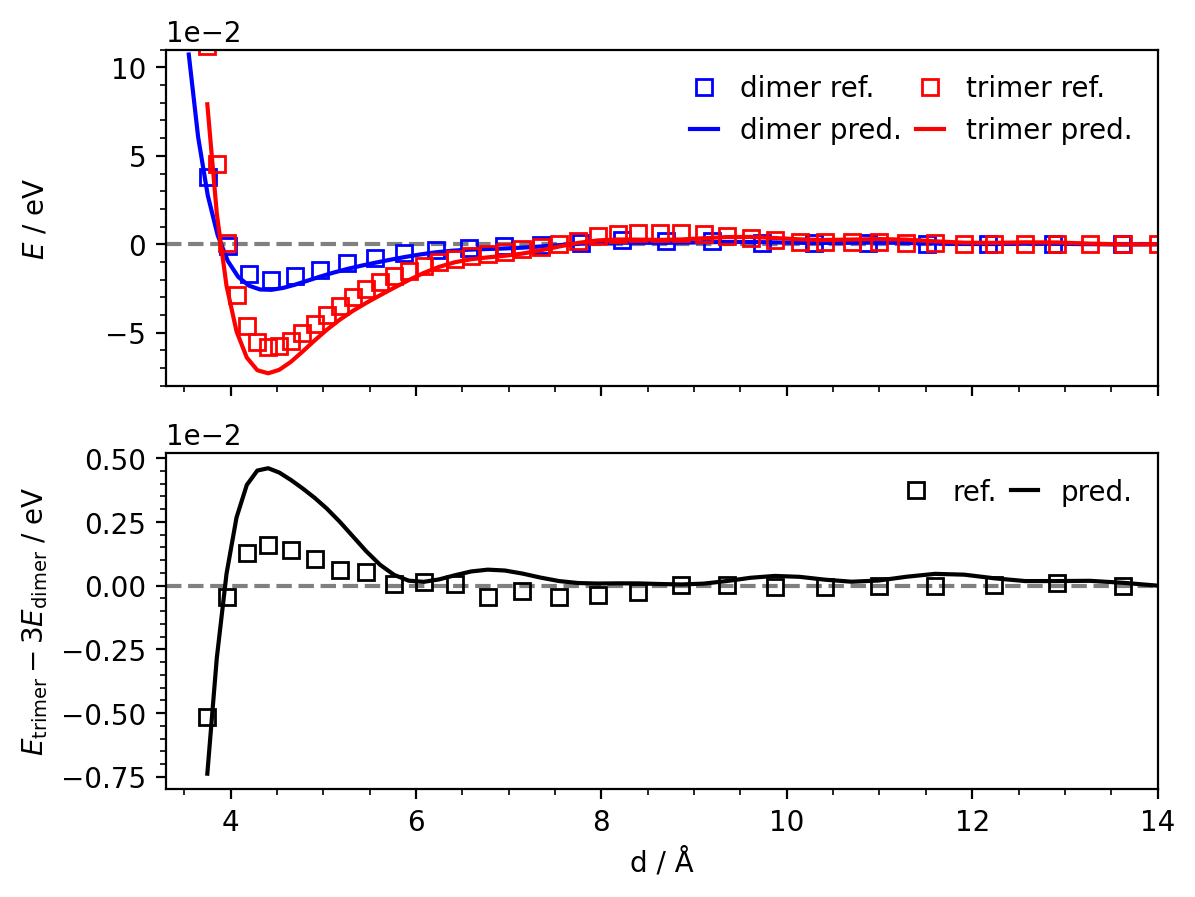

In [7]:
visualize_energy(dimer_dataset, dimer_energy - dimer_energy[-1], trimer_dataset, trimer_energy - trimer_energy[-1])